In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os
import shutil
import pandas as pd

Data link: https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images

In [2]:
new_base_dir = pathlib.Path("./Mushrooms")
new_dir = new_base_dir/"Selected_Mushrooms"

In [3]:
def load_image(im_path):
    img = tf.io.read_file(im_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (64, 64))
    

    
for root, folder, files in os.walk(new_dir):
    for file in files:
        file_path = os.path.join(root, file)
        load_image(file_path)



In [4]:
im_path = file_path
img = tf.io.read_file(im_path)
img = tf.image.decode_jpeg(img, channels=3)

In [5]:
dir=str(new_dir)
!ls $dir
!ls $dir/* | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
jpgfiles = new_dir.glob('*/*.jpg')
jpgfiles

<generator object Path.glob at 0x00000247ADF520B0>

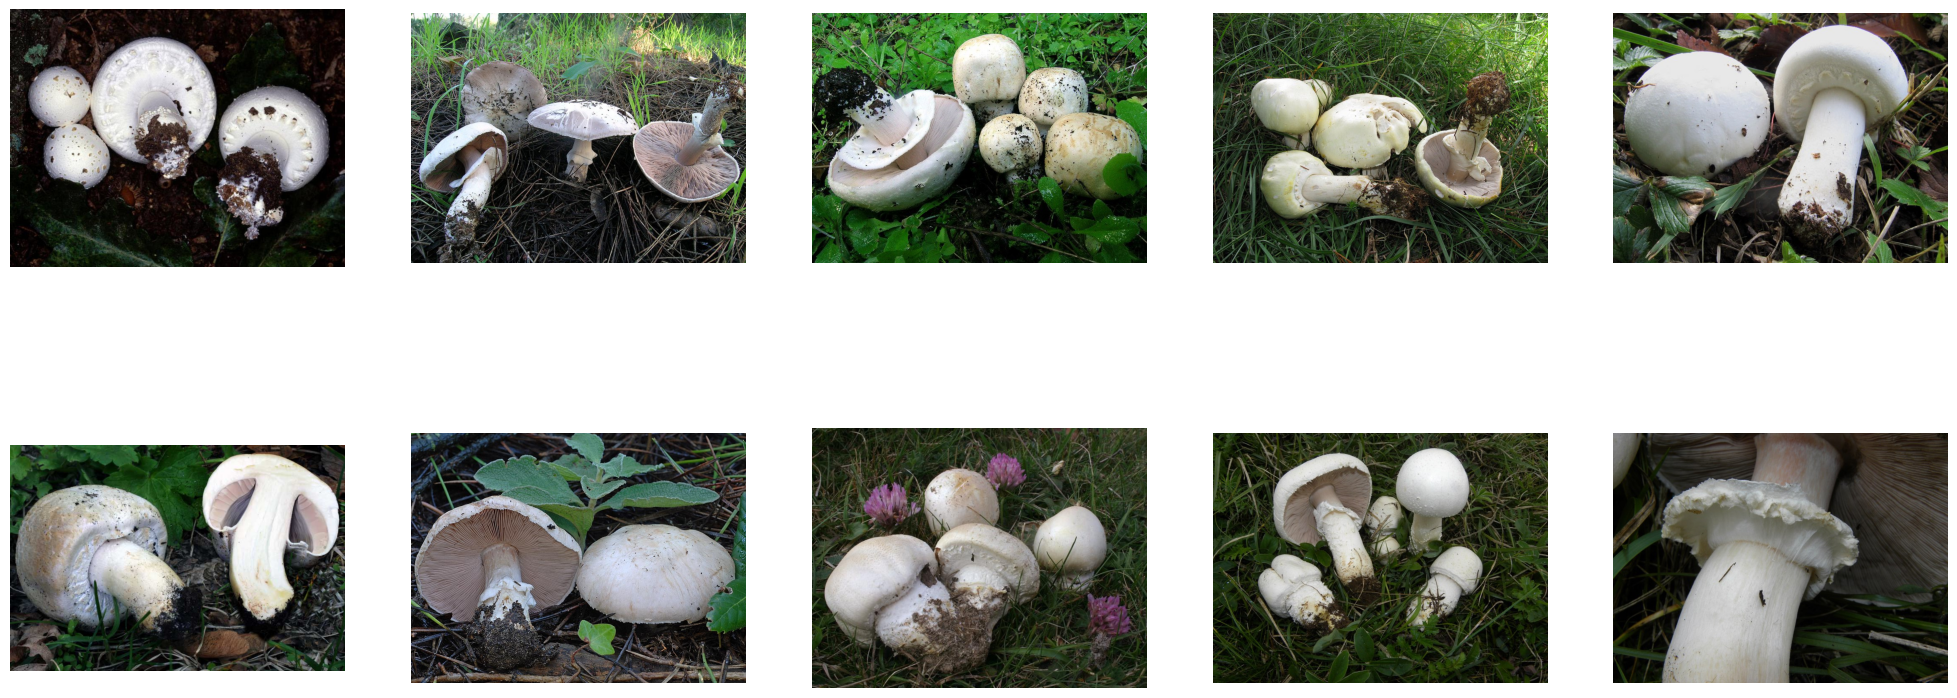

In [7]:
jpgfiles = new_dir.glob('*/*.jpg')

plt.figure(figsize=(25, 10))

for i, jpg in zip(range(10), jpgfiles):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(PIL.Image.open(str(jpg)))
    plt.axis("off")

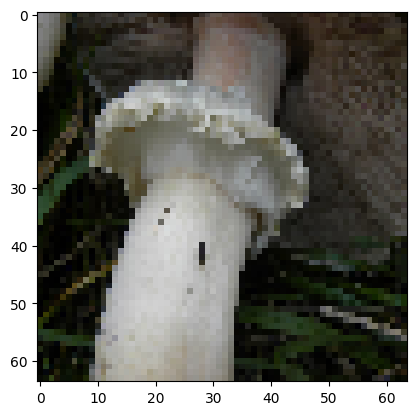

In [8]:
resize_layer = tf.keras.layers.Resizing(
    height = 64,
    width = 64,
    interpolation='bilinear'
)

img = np.array(PIL.Image.open(str(jpg)))
resized_img = resize_layer(img)

plt.imshow(resized_img.numpy().astype(int))

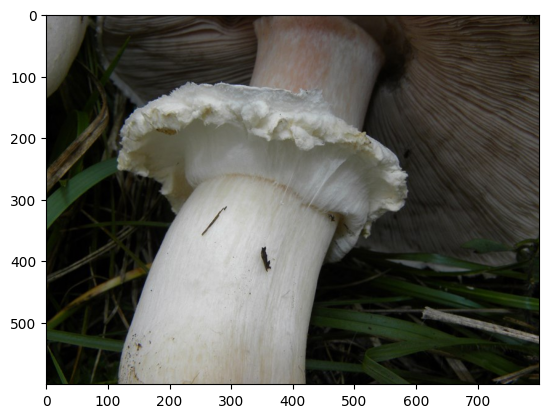

In [9]:
plt.imshow(img)

In [10]:
batch_size = 64
img_height = 64
img_width = 64

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  new_dir,
  validation_split=0.1,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6402 files belonging to 8 classes.
Using 5762 files for training.
Using 640 files for validation.


In [11]:
x, y = next(iter(train_ds))
x.shape, y.shape

(TensorShape([64, 64, 64, 3]), TensorShape([64]))

In [12]:
class_names = train_ds.class_names
print(class_names)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula']


In [13]:
# Initialize a dictionary to count the number of cases per class
class_counts = {class_name: 0 for class_name in class_names}

# Count the number of cases per class in the training set
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Print the results
for class_name in class_names:
    print(f"{class_name}: {class_counts[class_name]}")

Agaricus: 322
Amanita: 683
Boletus: 969
Cortinarius: 744
Entoloma: 322
Hygrocybe: 283
Lactarius: 1403
Russula: 1036


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation settings
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest')

# Create a new dataset using data augmentation
augmented_ds = datagen.flow_from_directory(
    new_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    shuffle=True,
    class_mode='categorical')

Found 6402 images belonging to 8 classes.


In [15]:
#Standrtize the dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

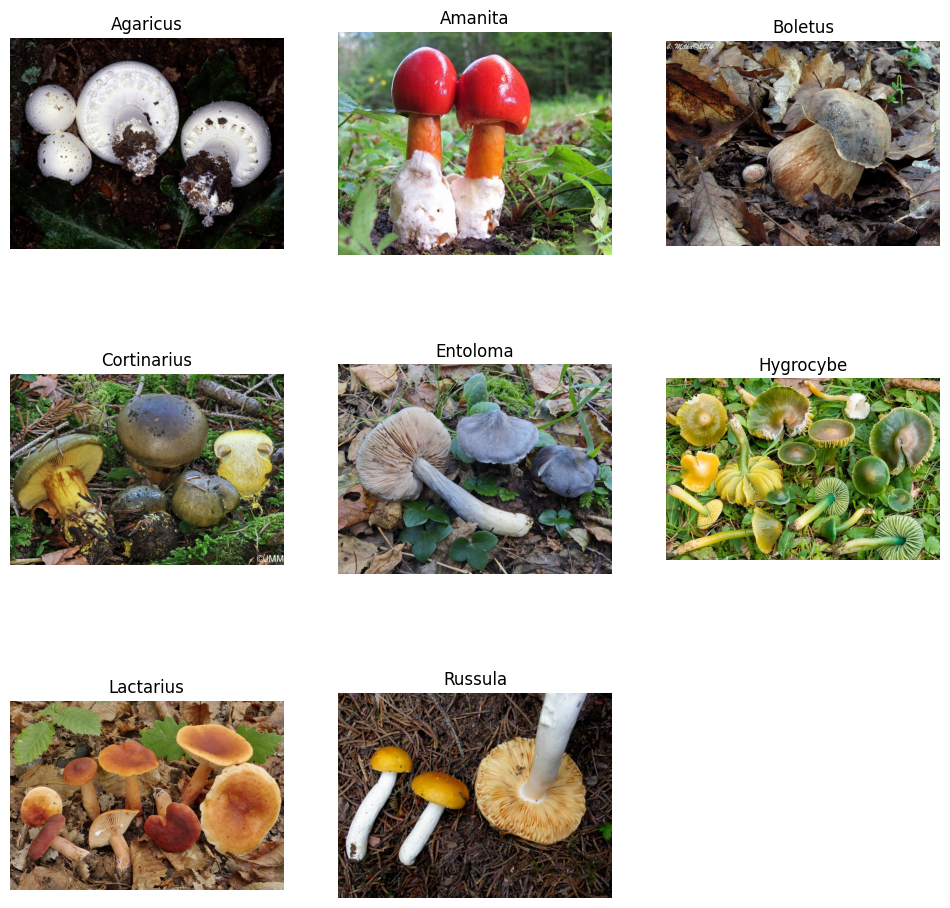

In [16]:
nrows = 3
ncols = 3
pos = 0
import matplotlib.image as mpimg
for subfolder in os.listdir(new_dir):
    
    image_file = os.listdir(os.path.join(new_dir, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(new_dir, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 64, 64, 3)
(64,)


In [18]:
data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

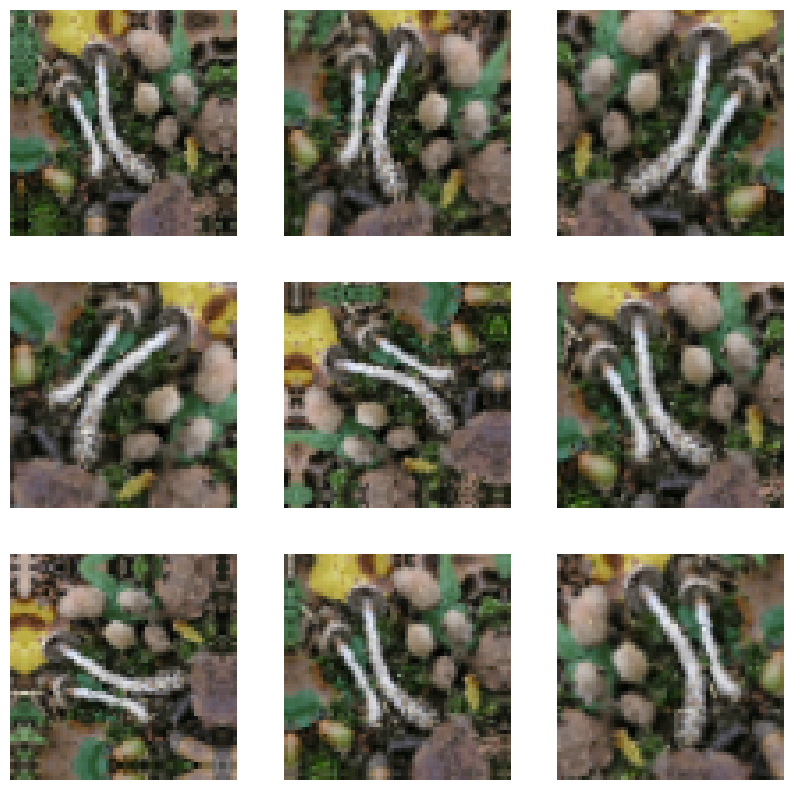

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
tf.data.AUTOTUNE

-1

In [22]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [23]:
input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))

conv1_8_3x3 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu')

maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2_8_2x2 = tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension


In [24]:
from tensorflow.keras.optimizers import Adam

model = tf.keras.models.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1_8_3x3,
        maxpool1,
        conv2_8_2x2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(3600/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                  

In [25]:
epochs=150
batch = 80
Table = pd.DataFrame()
history = model.fit(
  train_ds,
  validation_data=val_ds,
    batch_size=batch,
  epochs=epochs
)

Epoch 1/150


D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 15s 102ms/step - loss: 10.3008 - accuracy: 0.2055 - val_loss: 8.2671 - val_accuracy: 0.2547
Epoch 2/150
91/91 [==============================] - 9s 97ms/step - loss: 4.2798 - accuracy: 0.2397 - val_loss: 6.5359 - val_accuracy: 0.2031
Epoch 3/150
91/91 [==============================] - 9s 94ms/step - loss: 3.5303 - accuracy: 0.2466 - val_loss: 5.6934 - val_accuracy: 0.2250
Epoch 4/150
91/91 [==============================] - 9s 97ms/step - loss: 2.9348 - accuracy: 0.2700 - val_loss: 4.8592 - val_accuracy: 0.2344
Epoch 5/150
91/91 [==============================] - 9s 96ms/step - loss: 2.6805 - accuracy: 0.2626 - val_loss: 5.1017 - val_accuracy: 0.1813
Epoch 6/150
91/91 [==============================] - 9s 97ms/step - loss: 2.5244 - accuracy: 0.2779 - val_loss: 4.0620 - val_accuracy: 0.2266
Epoch 7/150
91/91 [==============================] - 9s 95ms/step - loss: 2.3278 - accuracy: 0.2864 - val_loss: 3.9140 - val_accuracy: 0.2203
Epoch 8/150
91/

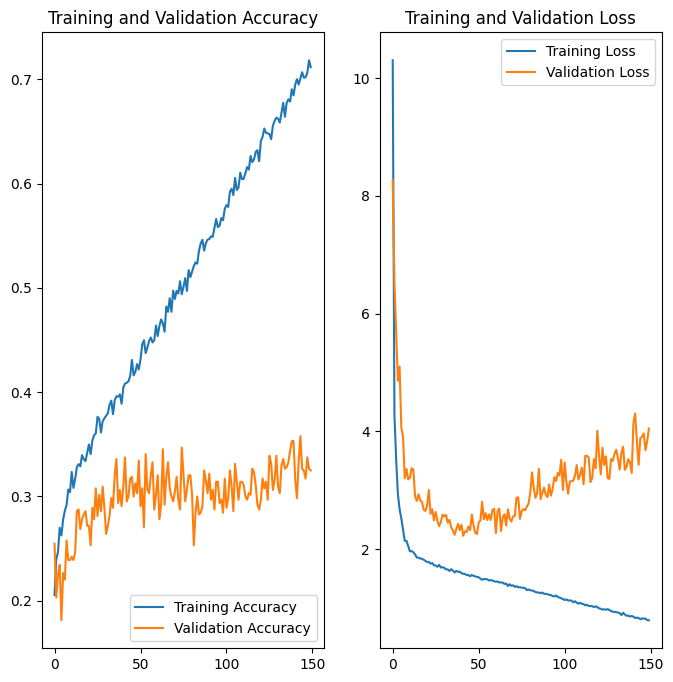

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
#model_f8_w3x3 
channels1 = 8
kernel1 = 3
epochs=150

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 8)         264       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                  

Epoch 1/150
91/91 [==============================] - 6s 58ms/step - loss: 47.3005 - accuracy: 0.1779 - val_loss: 2.4891 - val_accuracy: 0.2125
Epoch 2/150
91/91 [==============================] - 5s 56ms/step - loss: 2.0781 - accuracy: 0.2209 - val_loss: 2.2008 - val_accuracy: 0.2453
Epoch 3/150
91/91 [==============================] - 5s 59ms/step - loss: 1.9369 - accuracy: 0.2655 - val_loss: 2.1586 - val_accuracy: 0.2594
Epoch 4/150
91/91 [==============================] - 5s 58ms/step - loss: 1.8862 - accuracy: 0.2846 - val_loss: 2.1055 - val_accuracy: 0.2562
Epoch 5/150
91/91 [==============================] - 5s 57ms/step - loss: 1.8550 - accuracy: 0.2930 - val_loss: 2.1155 - val_accuracy: 0.2719
Epoch 6/150
91/91 [==============================] - 6s 61ms/step - loss: 1.8442 - accuracy: 0.2950 - val_loss: 1.9786 - val_accuracy: 0.2969
Epoch 7/150
91/91 [==============================] - 5s 57ms/step - loss: 1.8339 - accuracy: 0.2952 - val_loss: 2.0549 - val_accuracy: 0.2844
Epoch

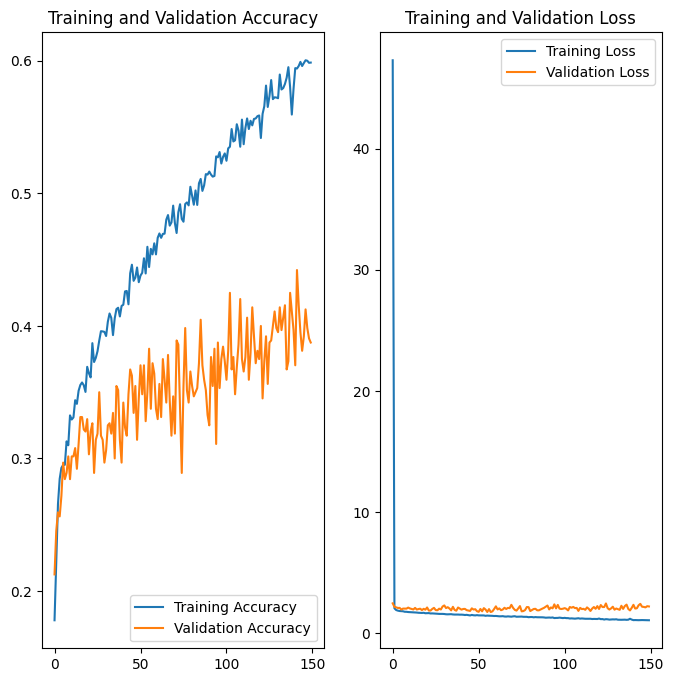

10/10 [==============================] - 0s 12ms/step - loss: 2.2316 - accuracy: 0.3875


List_channel  List_kernel     Acc  epochs
0             8            3  0.3875     150

In [28]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
    batch_size=batch,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_epochs = list()
List_epochs.append(epochs)
List_channel = list()
List_channel.append(channels1)
List_kernel = list()
List_kernel.append(kernel1)
Acc = list()
Acc.append(accuracy)

List_epochs = list()
List_epochs.append(epochs)
Table = pd.DataFrame({'List_channel' : List_channel,
                                'List_kernel' : List_kernel,
                                'Acc' : Acc,'epochs':List_epochs,}, 
                                columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [29]:
#model_f8_w5x5
channels1 = 8
kernel1 = 5

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1568/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 8)         608       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 8)         264       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                  

Epoch 1/150


D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 7s 64ms/step - loss: 11.1016 - accuracy: 0.2074 - val_loss: 2.3383 - val_accuracy: 0.2531
Epoch 2/150
91/91 [==============================] - 6s 61ms/step - loss: 1.9574 - accuracy: 0.2477 - val_loss: 2.2200 - val_accuracy: 0.2641
Epoch 3/150
91/91 [==============================] - 6s 66ms/step - loss: 1.9113 - accuracy: 0.2720 - val_loss: 2.1784 - val_accuracy: 0.2812
Epoch 4/150
91/91 [==============================] - 6s 66ms/step - loss: 1.8791 - accuracy: 0.2700 - val_loss: 2.1522 - val_accuracy: 0.2766
Epoch 5/150
91/91 [==============================] - 6s 64ms/step - loss: 1.8583 - accuracy: 0.2773 - val_loss: 2.1671 - val_accuracy: 0.2766
Epoch 6/150
91/91 [==============================] - 6s 68ms/step - loss: 1.8613 - accuracy: 0.2742 - val_loss: 2.1523 - val_accuracy: 0.2812
Epoch 7/150
91/91 [==============================] - 6s 65ms/step - loss: 1.8435 - accuracy: 0.2787 - val_loss: 2.1590 - val_accuracy: 0.2688
Epoch 8/150
91/91

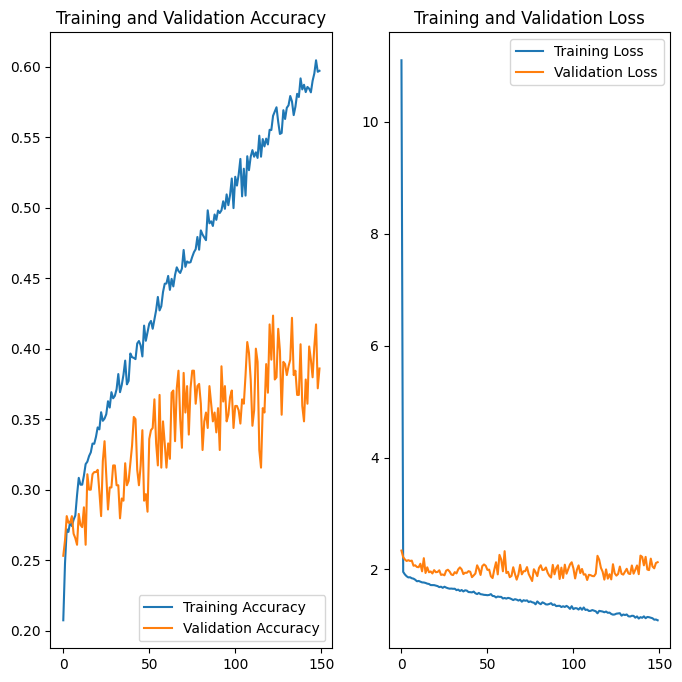

10/10 [==============================] - 0s 13ms/step - loss: 2.1310 - accuracy: 0.3859


List_channel  List_kernel       Acc  epochs
0             8            3  0.387500     150
1             8            5  0.385938     150

In [30]:
epochs=150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]


List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,
                                'List_kernel' : List_kernel,
                                'Acc' : Acc,'epochs':List_epochs}, 
                                columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [31]:
#model_f16_w3x3
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_4 (InputLayer)        multiple                  0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                  

Epoch 1/150


D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 8s 67ms/step - loss: 8.5697 - accuracy: 0.2034 - val_loss: 2.1650 - val_accuracy: 0.2250
Epoch 2/150
91/91 [==============================] - 6s 65ms/step - loss: 1.9603 - accuracy: 0.2320 - val_loss: 2.1110 - val_accuracy: 0.2203
Epoch 3/150
91/91 [==============================] - 6s 64ms/step - loss: 1.9250 - accuracy: 0.2449 - val_loss: 2.0695 - val_accuracy: 0.2406
Epoch 4/150
91/91 [==============================] - 6s 67ms/step - loss: 1.9121 - accuracy: 0.2586 - val_loss: 2.0802 - val_accuracy: 0.2234
Epoch 5/150
91/91 [==============================] - 6s 67ms/step - loss: 1.9105 - accuracy: 0.2546 - val_loss: 2.0474 - val_accuracy: 0.2547
Epoch 6/150
91/91 [==============================] - 6s 66ms/step - loss: 1.9042 - accuracy: 0.2565 - val_loss: 2.1048 - val_accuracy: 0.2562
Epoch 7/150
91/91 [==============================] - 6s 69ms/step - loss: 1.8922 - accuracy: 0.2598 - val_loss: 2.0836 - val_accuracy: 0.2562
Epoch 8/150
91/91 

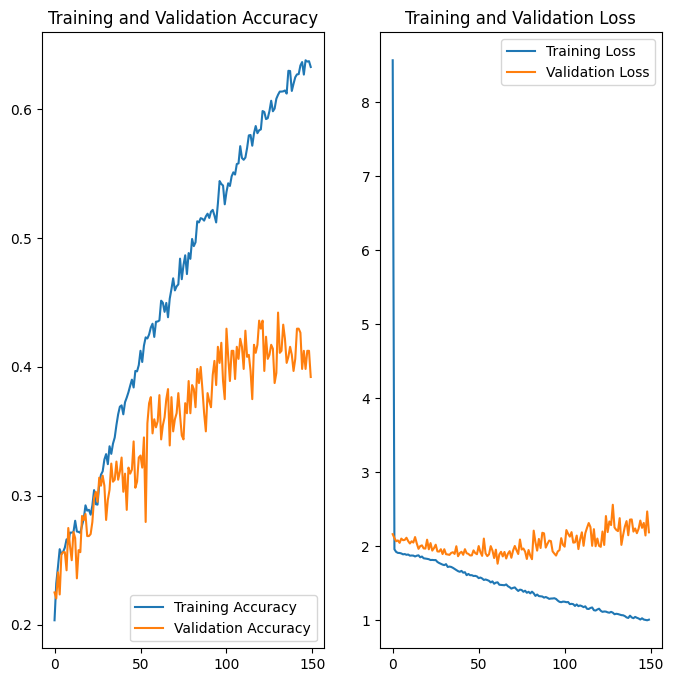

10/10 [==============================] - 0s 13ms/step - loss: 2.1897 - accuracy: 0.3922


List_channel  List_kernel       Acc  epochs
0             8            3  0.387500     150
1             8            5  0.385938     150
2            16            3  0.392188     150

In [32]:
epochs=150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]


List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,
                                'List_kernel' : List_kernel,
                                'Acc' : Acc,'epochs':List_epochs}, 
                                columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [33]:
#model_f16_w5x5
channels1 = 16
kernel1 = 5

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1568/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_5 (InputLayer)        multiple                  0         
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                  

Epoch 1/150


D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 8s 75ms/step - loss: 80.5915 - accuracy: 0.1833 - val_loss: 2.1876 - val_accuracy: 0.2313
Epoch 2/150
91/91 [==============================] - 7s 75ms/step - loss: 1.9738 - accuracy: 0.2234 - val_loss: 2.1269 - val_accuracy: 0.2219
Epoch 3/150
91/91 [==============================] - 7s 74ms/step - loss: 1.9250 - accuracy: 0.2548 - val_loss: 2.0180 - val_accuracy: 0.2547
Epoch 4/150
91/91 [==============================] - 7s 72ms/step - loss: 1.9129 - accuracy: 0.2596 - val_loss: 2.0592 - val_accuracy: 0.2578
Epoch 5/150
91/91 [==============================] - 7s 73ms/step - loss: 1.9007 - accuracy: 0.2515 - val_loss: 2.0556 - val_accuracy: 0.2547
Epoch 6/150
91/91 [==============================] - 7s 74ms/step - loss: 1.8897 - accuracy: 0.2602 - val_loss: 1.9728 - val_accuracy: 0.2453
Epoch 7/150
91/91 [==============================] - 6s 71ms/step - loss: 1.8826 - accuracy: 0.2624 - val_loss: 2.0570 - val_accuracy: 0.2594
Epoch 8/150
91/91

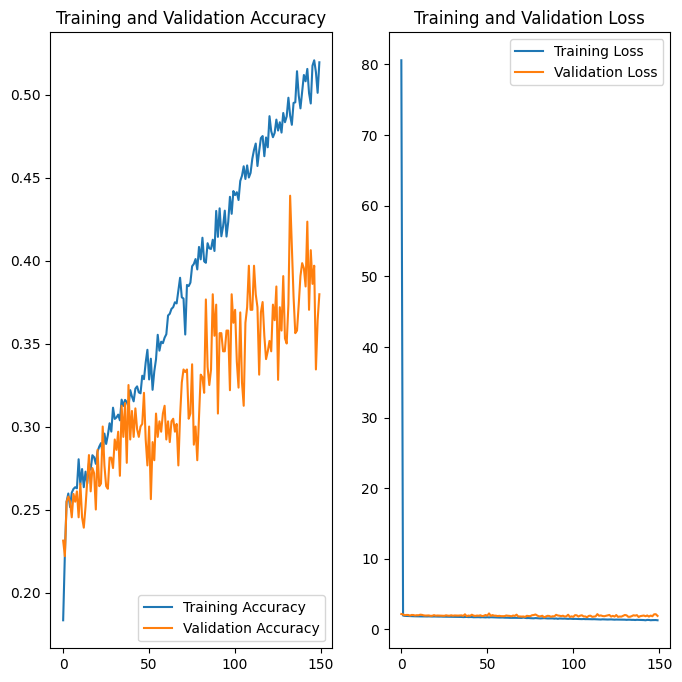

10/10 [==============================] - 0s 15ms/step - loss: 1.9241 - accuracy: 0.3797


List_channel  List_kernel       Acc  epochs
0             8            3  0.387500     150
1             8            5  0.385938     150
2            16            3  0.392188     150
3            16            5  0.379687     150

In [34]:
epochs=150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]


List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,
                                'List_kernel' : List_kernel,
                                'Acc' : Acc,'epochs':List_epochs}, 
                                columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [35]:
#model_f24_w3x3
channels1 = 24
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_6 (InputLayer)        multiple                  0         
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 24)        672       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 8)         776       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                 

Epoch 1/150


D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 8s 74ms/step - loss: 16.7261 - accuracy: 0.1973 - val_loss: 2.1399 - val_accuracy: 0.2359
Epoch 2/150
91/91 [==============================] - 7s 72ms/step - loss: 1.9682 - accuracy: 0.2374 - val_loss: 2.0359 - val_accuracy: 0.2219
Epoch 3/150
91/91 [==============================] - 7s 76ms/step - loss: 1.9406 - accuracy: 0.2390 - val_loss: 2.0033 - val_accuracy: 0.2344
Epoch 4/150
91/91 [==============================] - 7s 75ms/step - loss: 1.9290 - accuracy: 0.2343 - val_loss: 1.9926 - val_accuracy: 0.2469
Epoch 5/150
91/91 [==============================] - 7s 77ms/step - loss: 1.9282 - accuracy: 0.2405 - val_loss: 1.9883 - val_accuracy: 0.2422
Epoch 6/150
91/91 [==============================] - 7s 75ms/step - loss: 1.9192 - accuracy: 0.2412 - val_loss: 1.9825 - val_accuracy: 0.2500
Epoch 7/150
91/91 [==============================] - 7s 76ms/step - loss: 1.9265 - accuracy: 0.2352 - val_loss: 2.0084 - val_accuracy: 0.2438
Epoch 8/150
91/91

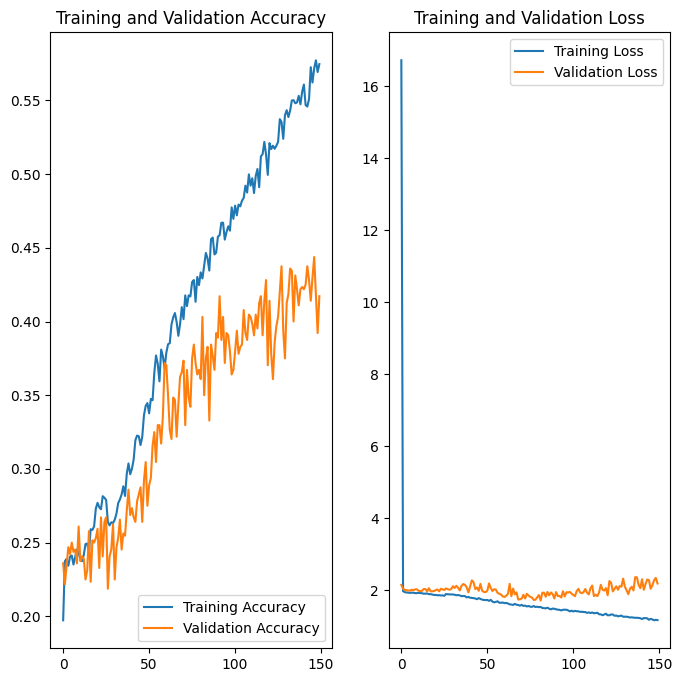

10/10 [==============================] - 0s 17ms/step - loss: 2.1808 - accuracy: 0.4172


List_channel  List_kernel       Acc  epochs
0             8            3  0.387500     150
1             8            5  0.385938     150
2            16            3  0.392188     150
3            16            5  0.379687     150
4            24            3  0.417188     150

In [36]:
epochs=150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]


List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,
                                'List_kernel' : List_kernel,
                                'Acc' : Acc,'epochs':List_epochs}, 
                                columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [37]:
#model_f24_w5x5
channels1 = 24
kernel1 = 5

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1568/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_7 (InputLayer)        multiple                  0         
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 24)        1824      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 8)         776       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                 

Epoch 1/150


D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 8s 80ms/step - loss: 4.1700 - accuracy: 0.2185 - val_loss: 1.9641 - val_accuracy: 0.2406
Epoch 2/150
91/91 [==============================] - 8s 84ms/step - loss: 1.9481 - accuracy: 0.2437 - val_loss: 1.9412 - val_accuracy: 0.2453
Epoch 3/150
91/91 [==============================] - 7s 82ms/step - loss: 1.9407 - accuracy: 0.2438 - val_loss: 1.9423 - val_accuracy: 0.2453
Epoch 4/150
91/91 [==============================] - 8s 87ms/step - loss: 1.9391 - accuracy: 0.2440 - val_loss: 1.9450 - val_accuracy: 0.2469
Epoch 5/150
91/91 [==============================] - 7s 82ms/step - loss: 1.9395 - accuracy: 0.2445 - val_loss: 1.9438 - val_accuracy: 0.2453
Epoch 6/150
91/91 [==============================] - 8s 86ms/step - loss: 1.9379 - accuracy: 0.2438 - val_loss: 1.9678 - val_accuracy: 0.2359
Epoch 7/150
91/91 [==============================] - 7s 82ms/step - loss: 1.9395 - accuracy: 0.2437 - val_loss: 1.9514 - val_accuracy: 0.2453
Epoch 8/150
91/91 

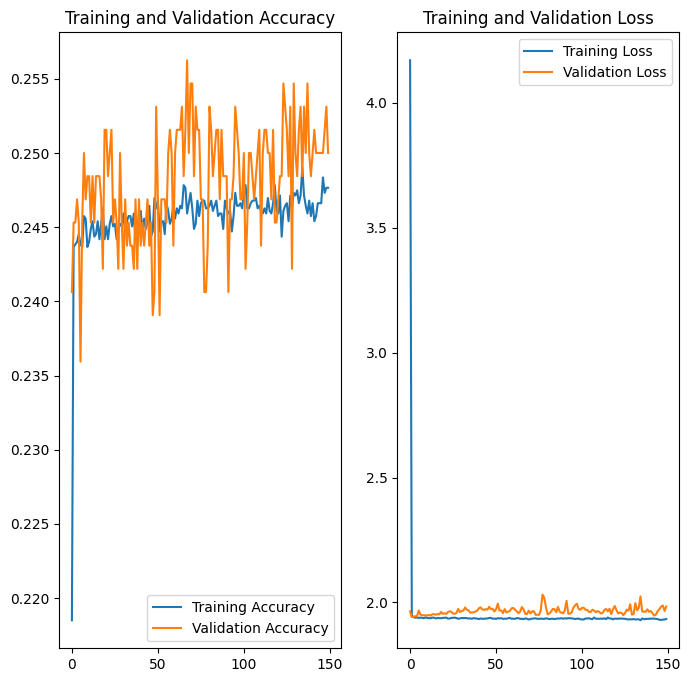

10/10 [==============================] - 0s 19ms/step - loss: 1.9840 - accuracy: 0.2500


List_channel  List_kernel       Acc  epochs
0             8            3  0.387500     150
1             8            5  0.385938     150
2            16            3  0.392188     150
3            16            5  0.379687     150
4            24            3  0.417188     150
5            24            5  0.250000     150

In [38]:
epochs=150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]


List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,
                                'List_kernel' : List_kernel,
                                'Acc' : Acc,'epochs':List_epochs}, 
                                columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

# #Best performance analysis
###Channel:16, Kernel:3

In [39]:
#model_f16_w3x3
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_8 (InputLayer)        multiple                  0         
                                                                 
 conv2d_14 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                 

Epoch 1/300
91/91 [==============================] - 7s 79ms/step - loss: 1.9327 - accuracy: 0.2470 - val_loss: 1.9866 - val_accuracy: 0.2500
Epoch 2/300
91/91 [==============================] - 8s 83ms/step - loss: 1.9382 - accuracy: 0.2452 - val_loss: 1.9671 - val_accuracy: 0.2516
Epoch 3/300
91/91 [==============================] - 7s 81ms/step - loss: 1.9345 - accuracy: 0.2466 - val_loss: 1.9607 - val_accuracy: 0.2484
Epoch 4/300
91/91 [==============================] - 8s 84ms/step - loss: 1.9337 - accuracy: 0.2459 - val_loss: 1.9658 - val_accuracy: 0.2531
Epoch 5/300
91/91 [==============================] - 7s 81ms/step - loss: 1.9340 - accuracy: 0.2457 - val_loss: 1.9772 - val_accuracy: 0.2547
Epoch 6/300
91/91 [==============================] - 8s 84ms/step - loss: 1.9365 - accuracy: 0.2464 - val_loss: 1.9975 - val_accuracy: 0.2469
Epoch 7/300
91/91 [==============================] - 7s 81ms/step - loss: 1.9311 - accuracy: 0.2480 - val_loss: 2.0331 - val_accuracy: 0.2438
Epoch 

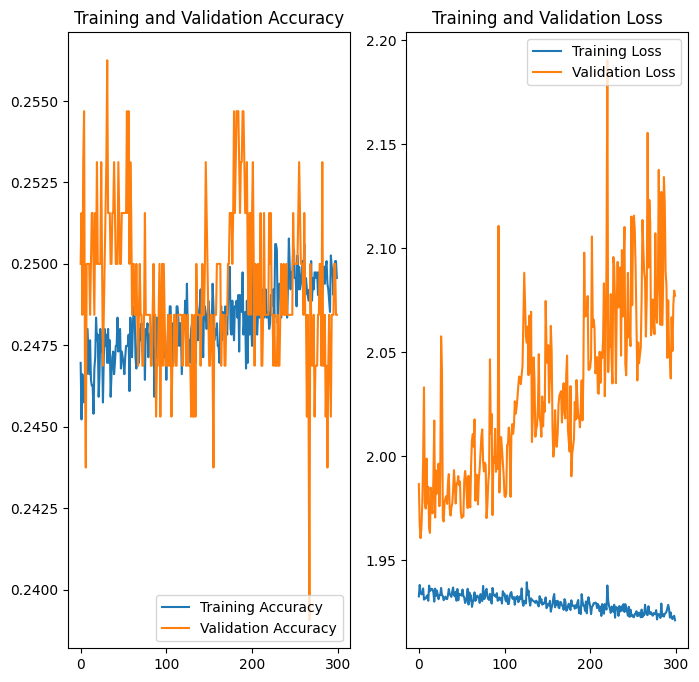

10/10 [==============================] - 0s 17ms/step - loss: 2.0771 - accuracy: 0.2484


List_channel  List_kernel       Acc  epochs
0             8            3  0.387500     150
1             8            5  0.385938     150
2            16            3  0.392188     150
3            16            5  0.379687     150
4            24            3  0.417188     150
5            24            5  0.250000     150
6            16            3  0.248437     300

In [40]:
epochs=300
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]


List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Best_Table = pd.DataFrame({'List_channel' : List_channel,
                                'List_kernel' : List_kernel,
                                'Acc' : Acc,'epochs':List_epochs}, 
                                columns=['List_channel','List_kernel','Acc', 'epochs'])
Best_Table

Epoch 1/100
91/91 [==============================] - 9s 96ms/step - loss: 1.9213 - accuracy: 0.2518 - val_loss: 2.0797 - val_accuracy: 0.2484
Epoch 2/100
91/91 [==============================] - 8s 92ms/step - loss: 1.9222 - accuracy: 0.2515 - val_loss: 2.0980 - val_accuracy: 0.2484
Epoch 3/100
91/91 [==============================] - 9s 96ms/step - loss: 1.9221 - accuracy: 0.2497 - val_loss: 2.1092 - val_accuracy: 0.2484
Epoch 4/100
91/91 [==============================] - 9s 97ms/step - loss: 1.9267 - accuracy: 0.2485 - val_loss: 2.0822 - val_accuracy: 0.2484
Epoch 5/100
91/91 [==============================] - 8s 93ms/step - loss: 1.9236 - accuracy: 0.2501 - val_loss: 2.0801 - val_accuracy: 0.2484
Epoch 6/100
91/91 [==============================] - 9s 96ms/step - loss: 1.9220 - accuracy: 0.2515 - val_loss: 2.1247 - val_accuracy: 0.2531
Epoch 7/100
91/91 [==============================] - 8s 92ms/step - loss: 1.9246 - accuracy: 0.2485 - val_loss: 2.0308 - val_accuracy: 0.2516
Epoch 

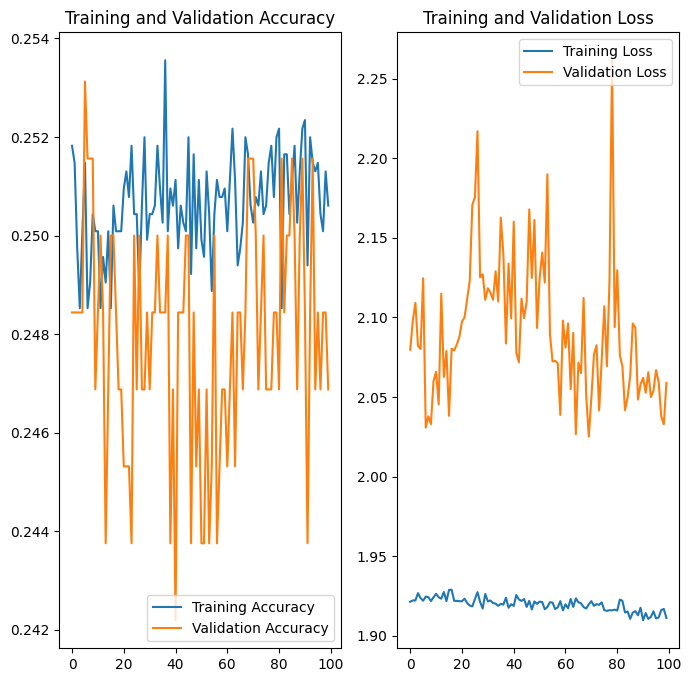

10/10 [==============================] - 0s 19ms/step - loss: 2.0589 - accuracy: 0.2469


List_channel  List_kernel       Acc  epochs
0             8            3  0.387500     150
1             8            5  0.385938     150
2            16            3  0.392188     150
3            16            5  0.379687     150
4            24            3  0.417188     150
5            24            5  0.250000     150
6            16            3  0.248437     300
7            16            3  0.246875     100

In [41]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]


List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Best_Table = pd.DataFrame({'List_channel' : List_channel,
                                'List_kernel' : List_kernel,
                                'Acc' : Acc,'epochs':List_epochs}, 
                                columns=['List_channel','List_kernel','Acc', 'epochs'])
Best_Table

In [42]:
Best_Table

List_channel  List_kernel       Acc  epochs
0             8            3  0.387500     150
1             8            5  0.385938     150
2            16            3  0.392188     150
3            16            5  0.379687     150
4            24            3  0.417188     150
5            24            5  0.250000     150
6            16            3  0.248437     300
7            16            3  0.246875     100

Epoch 1/150


D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 8s 69ms/step - loss: 56.2019 - accuracy: 0.1795 - val_loss: 2.3140 - val_accuracy: 0.2125
Epoch 2/150
91/91 [==============================] - 7s 76ms/step - loss: 1.9998 - accuracy: 0.2339 - val_loss: 2.1990 - val_accuracy: 0.2359
Epoch 3/150
91/91 [==============================] - 6s 68ms/step - loss: 1.9507 - accuracy: 0.2461 - val_loss: 2.1147 - val_accuracy: 0.2188
Epoch 4/150
91/91 [==============================] - 7s 75ms/step - loss: 1.9341 - accuracy: 0.2490 - val_loss: 2.1270 - val_accuracy: 0.2297
Epoch 5/150
91/91 [==============================] - 7s 73ms/step - loss: 1.9179 - accuracy: 0.2518 - val_loss: 2.1591 - val_accuracy: 0.2297
Epoch 6/150
91/91 [==============================] - 6s 71ms/step - loss: 1.9115 - accuracy: 0.2418 - val_loss: 2.0797 - val_accuracy: 0.2594
Epoch 7/150
91/91 [==============================] - 7s 75ms/step - loss: 1.9023 - accuracy: 0.2506 - val_loss: 2.0458 - val_accuracy: 0.2562
Epoch 8/150
91/91

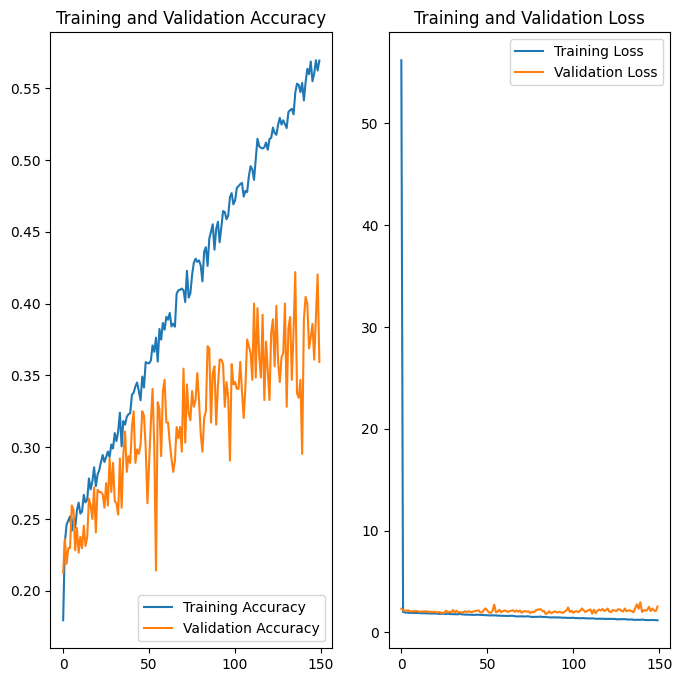

10/10 [==============================] - 0s 21ms/step
Confusion matrix (as percentages per class):
[[  0.     3.23   0.     0.     0.     0.    96.77   0.  ]
 [  0.     0.     0.     0.     0.     0.    98.51   1.49]
 [  0.     0.96   0.     0.     0.     0.    99.04   0.  ]
 [  0.     0.     0.     1.09   0.     0.    98.91   0.  ]
 [  0.     0.     0.     2.38   0.     0.    97.62   0.  ]
 [  0.     0.     0.     0.     0.     0.   100.     0.  ]
 [  0.     0.62   0.     0.     0.     0.    96.88   2.5 ]
 [  0.9    0.     0.     0.     0.9    0.    96.4    1.8 ]]


In [43]:
epochs=150
history = best_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

from sklearn.metrics import confusion_matrix

# Get the true labels and predictions for the test set
test_labels = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds, verbose=1)
pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Normalize the confusion matrix per class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix as percentages per class
print("Confusion matrix (as percentages per class):")
print(np.round(cm_norm * 100, decimals=2))

In [44]:
# Extract all the Zn configurations from the test set
Zn_list = []
combined_ds = val_ds.concatenate(val_ds)
for x, y in combined_ds:
    Zn = best_model.layers[6](x)  # assuming flatten layer is at index 6
    Zn_list.append(Zn.numpy())
Zn = np.concatenate(Zn_list, axis=0)

In [45]:
# Standardize the extracted configurations
Zn_std = (Zn - np.mean(Zn, axis=0)) / np.std(Zn, axis=0)

# Compute the covariance matrix
cov_mat = np.cov(Zn_std, rowvar=False)

# Compute the eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Sort the eigenvalues in descending order and calculate the cumulative sum
eig_vals_sorted = np.sort(eig_vals)[::-1]
cumsum = np.cumsum(eig_vals_sorted)
cumsum_percent = cumsum / cumsum[-1] * 100

# Determine the number of principal components required to explain 99% of the variance
n_components = np.argmax(cumsum_percent > 99) + 1

print(f"Number of principal components required to explain 99% of the variance: {n_components}")

Number of principal components required to explain 99% of the variance: 582


In [46]:
#model_f16_w3x3
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(n_components, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



accuracy = best_model.evaluate(val_ds)[1]

Hid = list()
Hid.append('R')

Accu = list()
Accu.append(accuracy)



H_Table = pd.DataFrame({'h' : Hid,
                                'Accuracy' : Accu}, 
                                columns=['h','Accuracy'])
H_Table

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_9 (InputLayer)        multiple                  0         
                                                                 
 conv2d_16 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                 

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 8s 69ms/step - loss: 8.9055 - accuracy: 0.2069 - val_loss: 2.1029 - val_accuracy: 0.2219
Epoch 2/150
91/91 [==============================] - 6s 68ms/step - loss: 1.9754 - accuracy: 0.2398 - val_loss: 2.0595 - val_accuracy: 0.2141
Epoch 3/150
91/91 [==============================] - 6s 65ms/step - loss: 1.9499 - accuracy: 0.2383 - val_loss: 2.0126 - val_accuracy: 0.2219
Epoch 4/150
91/91 [==============================] - 7s 81ms/step - loss: 1.9381 - accuracy: 0.2430 - val_loss: 2.0078 - val_accuracy: 0.2219
Epoch 5/150
91/91 [==============================] - 7s 80ms/step - loss: 1.9373 - accuracy: 0.2430 - val_loss: 2.0231 - val_accuracy: 0.2172
Epoch 6/150
91/91 [==============================] - 7s 81ms/step - loss: 1.9369 - accuracy: 0.2407 - val_loss: 2.0338 - val_accuracy: 0.2016
Epoch 7/150
91/91 [==============================] - 7s 81ms/step - loss: 1.9318 - accuracy: 0.2426 - val_loss: 2.0437 - val_accuracy: 0.2016
Epoch 8/150
91/91 

h  Accuracy
0  R  0.401563

In [47]:
#model_f16_w3x3
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(2*n_components, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



accuracy = best_model.evaluate(val_ds)[1]


Hid.append('2R')


Accu.append(accuracy)



H_Table = pd.DataFrame({'h' : Hid,
                                'Accuracy' : Accu}, 
                                columns=['h','Accuracy'])
H_Table

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_10 (InputLayer)       multiple                  0         
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 9s 83ms/step - loss: 27.5444 - accuracy: 0.2150 - val_loss: 2.1230 - val_accuracy: 0.2406
Epoch 2/150
91/91 [==============================] - 7s 73ms/step - loss: 1.9744 - accuracy: 0.2412 - val_loss: 2.1313 - val_accuracy: 0.2438
Epoch 3/150
91/91 [==============================] - 7s 80ms/step - loss: 1.9343 - accuracy: 0.2574 - val_loss: 2.1689 - val_accuracy: 0.2438
Epoch 4/150
91/91 [==============================] - 7s 75ms/step - loss: 1.9199 - accuracy: 0.2581 - val_loss: 2.0885 - val_accuracy: 0.2688
Epoch 5/150
91/91 [==============================] - 7s 78ms/step - loss: 1.9152 - accuracy: 0.2621 - val_loss: 2.0517 - val_accuracy: 0.2797
Epoch 6/150
91/91 [==============================] - 7s 78ms/step - loss: 1.9112 - accuracy: 0.2655 - val_loss: 2.0302 - val_accuracy: 0.2703
Epoch 7/150
91/91 [==============================] - 7s 74ms/step - loss: 1.8965 - accuracy: 0.2657 - val_loss: 2.0673 - val_accuracy: 0.2500
Epoch 8/150
91/91

h  Accuracy
0   R  0.401563
1  2R  0.414062

In [48]:
#model_f16_w3x3
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



accuracy = best_model.evaluate(val_ds)[1]


Hid.append('F/2')


Accu.append(accuracy)



H_Table = pd.DataFrame({'h' : Hid,
                                'Accuracy' : Accu}, 
                                columns=['h','Accuracy'])
H_Table

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_11 (InputLayer)       multiple                  0         
                                                                 
 conv2d_20 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 9s 84ms/step - loss: 4.3495 - accuracy: 0.2077 - val_loss: 2.2360 - val_accuracy: 0.2359
Epoch 2/150
91/91 [==============================] - 8s 90ms/step - loss: 1.9672 - accuracy: 0.2392 - val_loss: 2.1167 - val_accuracy: 0.2359
Epoch 3/150
91/91 [==============================] - 7s 83ms/step - loss: 1.9443 - accuracy: 0.2430 - val_loss: 2.0648 - val_accuracy: 0.2422
Epoch 4/150
91/91 [==============================] - 8s 89ms/step - loss: 1.9465 - accuracy: 0.2437 - val_loss: 2.0223 - val_accuracy: 0.2422
Epoch 5/150
91/91 [==============================] - 8s 83ms/step - loss: 1.9422 - accuracy: 0.2428 - val_loss: 2.0087 - val_accuracy: 0.2469
Epoch 6/150
91/91 [==============================] - 8s 89ms/step - loss: 1.9394 - accuracy: 0.2430 - val_loss: 2.0065 - val_accuracy: 0.2469
Epoch 7/150
91/91 [==============================] - 8s 83ms/step - loss: 1.9400 - accuracy: 0.2452 - val_loss: 1.9872 - val_accuracy: 0.2422
Epoch 8/150
91/91 

h  Accuracy
0    R  0.401563
1   2R  0.414062
2  F/2  0.370313

In [49]:
#model_f16_w3x3
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(2*n_components, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_12 (InputLayer)       multiple                  0         
                                                                 
 conv2d_22 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 8s 77ms/step - loss: 10.2437 - accuracy: 0.2088 - val_loss: 2.0215 - val_accuracy: 0.2188
Epoch 2/150
91/91 [==============================] - 8s 84ms/step - loss: 1.9555 - accuracy: 0.2385 - val_loss: 1.9568 - val_accuracy: 0.2516
Epoch 3/150
91/91 [==============================] - 7s 75ms/step - loss: 1.9421 - accuracy: 0.2419 - val_loss: 1.9547 - val_accuracy: 0.2297
Epoch 4/150
91/91 [==============================] - 7s 82ms/step - loss: 1.9399 - accuracy: 0.2435 - val_loss: 1.9750 - val_accuracy: 0.2281
Epoch 5/150
91/91 [==============================] - 7s 78ms/step - loss: 1.9386 - accuracy: 0.2437 - val_loss: 1.9702 - val_accuracy: 0.2250
Epoch 6/150
91/91 [==============================] - 7s 81ms/step - loss: 1.9415 - accuracy: 0.2411 - val_loss: 1.9493 - val_accuracy: 0.2422
Epoch 7/150
91/91 [==============================] - 7s 79ms/step - loss: 1.9369 - accuracy: 0.2438 - val_loss: 1.9665 - val_accuracy: 0.2406
Epoch 8/150
91/91

In [50]:
# Get the true labels and predictions for the test set
test_labels = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = best_model.predict(val_ds, verbose=1)
pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Normalize the confusion matrix per class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix as percentages per class
print("Confusion matrix (as percentages per class):")
print(np.round(cm_norm * 100, decimals=2))

10/10 [==============================] - 0s 20ms/step
Confusion matrix (as percentages per class):
[[25.81  3.23  6.45 19.35  0.    3.23 25.81 16.13]
 [16.42 19.4   4.48 16.42  2.99  1.49 25.37 13.43]
 [ 0.96  0.96 43.27  7.69  0.96  5.77 33.65  6.73]
 [ 1.09  1.09  7.61 38.04  3.26  6.52 30.43 11.96]
 [ 7.14  4.76  0.   35.71  9.52  0.   35.71  7.14]
 [ 0.    0.    3.03 21.21  3.03 36.36 21.21 15.15]
 [ 1.88  0.62  3.75 16.88  1.88  2.5  65.62  6.88]
 [ 1.8   4.5   4.5  10.81  1.8   0.9  36.04 39.64]]


In [51]:
#CL3 CL7
class_names = ['Boletus', 'Lactarius']

# Define a function to filter out images not in the selected classes
def filter_classes(x, y):
    mask = tf.logical_or(tf.equal(y, 2), tf.equal(y, 6))
    return x[mask], y[mask]

# Apply the filter to the training set
train_ds_3_7 = train_ds.map(filter_classes)

# Apply the filter to the validation set
val_ds_3_7 = val_ds.map(filter_classes)

In [52]:
#model_f16_w3x3
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(2*n_components, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
  train_ds_3_7,
  validation_data=val_ds_3_7,
  epochs=epochs
)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_13 (InputLayer)       multiple                  0         
                                                                 
 conv2d_24 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


91/91 [==============================] - 5s 48ms/step - loss: 16.2558 - accuracy: 0.5670 - val_loss: 1.3162 - val_accuracy: 0.6477
Epoch 2/150
91/91 [==============================] - 4s 47ms/step - loss: 0.6802 - accuracy: 0.6223 - val_loss: 1.1002 - val_accuracy: 0.6402
Epoch 3/150
91/91 [==============================] - 4s 46ms/step - loss: 0.6457 - accuracy: 0.6480 - val_loss: 0.9674 - val_accuracy: 0.6402
Epoch 4/150
91/91 [==============================] - 4s 47ms/step - loss: 0.6321 - accuracy: 0.6513 - val_loss: 0.8941 - val_accuracy: 0.6477
Epoch 5/150
91/91 [==============================] - 4s 45ms/step - loss: 0.6268 - accuracy: 0.6459 - val_loss: 0.8969 - val_accuracy: 0.6477
Epoch 6/150
91/91 [==============================] - 4s 46ms/step - loss: 0.6221 - accuracy: 0.6383 - val_loss: 0.8663 - val_accuracy: 0.6591
Epoch 7/150
91/91 [==============================] - 4s 47ms/step - loss: 0.6121 - accuracy: 0.6476 - val_loss: 0.7883 - val_accuracy: 0.6667
Epoch 8/150
91/91

In [71]:
# Get the true labels and predictions for the test set
test_labels = np.concatenate([y for x, y in val_ds_3_7], axis=0)
y_pred = best_model.predict(val_ds_3_7, verbose=1)
pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Normalize the confusion matrix per class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix as percentages per class
print("Confusion matrix (as percentages per class):")
print(np.round(cm_norm * 100, decimals=2))

10/10 [==============================] - 0s 12ms/step
Confusion matrix (as percentages per class):
[[79.81 20.19]
 [18.12 81.88]]


In [68]:
pred_labels.shape,y_pred.shape

((264,), (264, 8))

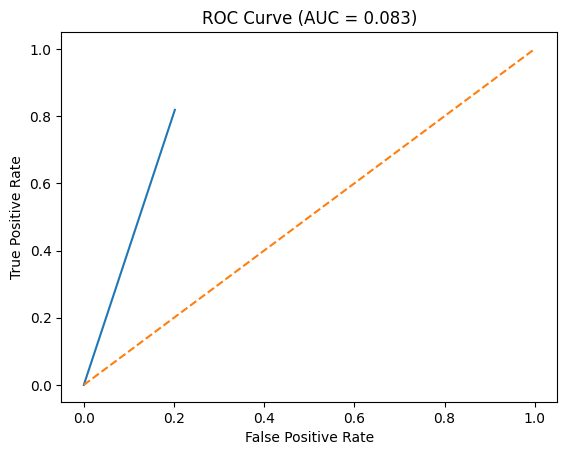

In [72]:

# Compute true positive and false positive rates
tn, fp, fn, tp = cm.ravel()
tpr[i] = tp / (tp + fn)
fpr[i] = fp / (fp + tn)

# Compute area under the curve (AUC)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.3f})')
plt.show()

array([0.00000000e+00, 1.94378874e-17, 9.78549414e-21, 6.60828176e-31,
       6.62332953e-33, 3.02977910e-28, 5.07878138e-33, 1.22449836e-30,
       0.00000000e+00, 3.26231589e-14, 9.14254701e-21, 2.58254571e-26,
       4.24625372e-16, 3.68744566e-29, 2.44037745e-19, 7.23656180e-17,
       2.87801054e-19, 1.48046339e-35, 1.61812969e-32, 1.72555078e-11,
       7.22862733e-20, 1.08053110e-23, 0.00000000e+00, 0.00000000e+00,
       1.17709114e-18, 0.00000000e+00, 1.78808350e-22, 1.53787453e-30,
       2.29118959e-18, 2.64340599e-18, 1.61725817e-13, 9.63118108e-35,
       3.92513773e-34, 1.71377010e-10, 1.00149317e-21, 3.10419577e-25,
       7.21713329e-32, 5.75613140e-15, 7.47256910e-33, 0.00000000e+00,
       2.77883543e-23, 9.67458942e-14, 4.24825263e-26, 4.62153727e-24,
       0.00000000e+00, 3.20659649e-35, 4.11055917e-23, 1.24760825e-13,
       3.47971476e-27, 9.96483109e-08, 5.53331265e-05, 1.31027681e-21,
       3.33643574e-26, 3.03892606e-29, 0.00000000e+00, 3.78654250e-18,
      